In [4]:
import sys, platform, subprocess, os

print("Python:", platform.python_version())
!nvidia-smi || true

!pip -q install "cupy-cuda12x" opencv-python-headless matplotlib


Python: 3.12.12
Thu Nov  6 21:58:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P0             26W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------------------------

Saving hero-main.jpg to hero-main.jpg
Imagen: hero-main.jpg shape: (1080, 1920)


(np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5))

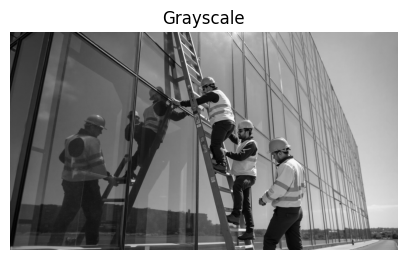

In [5]:
from google.colab import files
import numpy as np
import cv2
from matplotlib import pyplot as plt

uploaded = files.upload()
fname = next(iter(uploaded))
img_bgr = cv2.imread(fname)
if img_bgr is None:
    raise RuntimeError("No se pudo leer la imagen. Sube un .jpg o .png válido.")
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
h, w = img_gray.shape
print("Imagen:", fname, "shape:", img_gray.shape)

plt.figure(figsize=(5,5))
plt.imshow(img_gray, cmap="gray")
plt.title("Grayscale")
plt.axis("off")


Tiempo CPU: 20.474913 s


Text(0.5, 1.0, 'Sobel CPU')

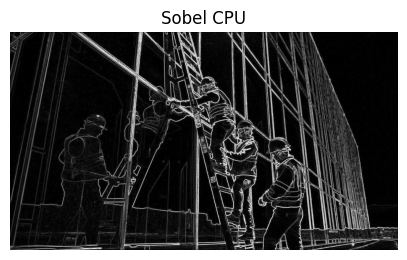

In [6]:
import time
import numpy as np

Kx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]], dtype=np.int16)
Ky = np.array([[ 1,  2,  1],
               [ 0,  0,  0],
               [-1, -2, -1]], dtype=np.int16)

def sobel_cpu_naive(gray: np.ndarray) -> np.ndarray:
    h, w = gray.shape
    out = np.zeros_like(gray, dtype=np.uint8)
    g = gray.astype(np.int32)

    for y in range(1, h-1):
        ym1, y0, yp1 = y-1, y, y+1
        for x in range(1, w-1):
            xm1, x0, xp1 = x-1, x, x+1
            p00, p01, p02 = g[ym1, xm1], g[ym1, x0], g[ym1, xp1]
            p10, p11, p12 = g[ y0, xm1], g[ y0, x0], g[ y0, xp1]
            p20, p21, p22 = g[yp1, xm1], g[yp1, x0], g[yp1, xp1]

            gx = (Kx[0,0]*p00 + Kx[0,1]*p01 + Kx[0,2]*p02 +
                  Kx[1,0]*p10 + Kx[1,1]*p11 + Kx[1,2]*p12 +
                  Kx[2,0]*p20 + Kx[2,1]*p21 + Kx[2,2]*p22)

            gy = (Ky[0,0]*p00 + Ky[0,1]*p01 + Ky[0,2]*p02 +
                  Ky[1,0]*p10 + Ky[1,1]*p11 + Ky[1,2]*p12 +
                  Ky[2,0]*p20 + Ky[2,1]*p21 + Ky[2,2]*p22)

            mag = int(np.sqrt(gx*gx + gy*gy))
            if mag > 255: mag = 255
            out[y, x] = mag
    return out

t0 = time.perf_counter()
sobel_cpu = sobel_cpu_naive(img_gray)
t1 = time.perf_counter()
cpu_s = t1 - t0
print(f"Tiempo CPU: {cpu_s:.6f} s")

plt.figure(figsize=(5,5))
plt.imshow(sobel_cpu, cmap="gray"); plt.axis("off"); plt.title("Sobel CPU")

Tiempo GPU (kernel): 0.000336 s


Text(0.5, 1.0, 'Sobel GPU')

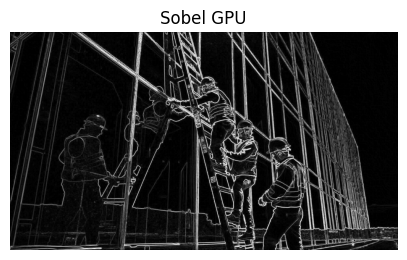

In [7]:
import cupy as cp
import time

sobel_kernel = r'''
extern "C" __global__
void sobel_u8(const unsigned char* __restrict__ gray,
              unsigned char* __restrict__ out,
              const int width, const int height)
{
    int x = blockDim.x * blockIdx.x + threadIdx.x;
    int y = blockDim.y * blockIdx.y + threadIdx.y;

    if (x >= width || y >= height) return;

    // Borde: escribir 0 para evitar accesos fuera de rango
    if (x == 0 || y == 0 || x == width-1 || y == height-1) {
        out[y*width + x] = 0;
        return;
    }

    // Lectura vecinos 3x3
    int xm1 = x - 1, xp1 = x + 1;
    int ym1 = y - 1, yp1 = y + 1;
    int p00 = gray[ym1*width + xm1];
    int p01 = gray[ym1*width +  x ];
    int p02 = gray[ym1*width + xp1];
    int p10 = gray[ y *width + xm1];
    int p11 = gray[ y *width +  x ];
    int p12 = gray[ y *width + xp1];
    int p20 = gray[yp1*width + xm1];
    int p21 = gray[yp1*width +  x ];
    int p22 = gray[yp1*width + xp1];

    // Sobel Gx, Gy
    int gx = (-1*p00) + ( 0*p01) + ( 1*p02)
           + (-2*p10) + ( 0*p11) + ( 2*p12)
           + (-1*p20) + ( 0*p21) + ( 1*p22);

    int gy = ( 1*p00) + ( 2*p01) + ( 1*p02)
           + ( 0*p10) + ( 0*p11) + ( 0*p12)
           + (-1*p20) + (-2*p21) + (-1*p22);

    float mag = sqrtf((float)(gx*gx + gy*gy));
    if (mag > 255.0f) mag = 255.0f;
    out[y*width + x] = (unsigned char)(mag);
}
''';

module = cp.RawModule(code=sobel_kernel, options=("-std=c++11",), name_expressions=["sobel_u8"])
sobel_u8 = module.get_function("sobel_u8")

d_gray = cp.asarray(img_gray)
d_out  = cp.empty_like(d_gray)

block = (16, 16, 1)
grid  = ((w + block[0]-1)//block[0], (h + block[1]-1)//block[1], 1)

start_evt = cp.cuda.Event()
stop_evt  = cp.cuda.Event()
start_evt.record()
sobel_u8(grid, block, (d_gray, d_out, np.int32(w), np.int32(h)))
stop_evt.record(); stop_evt.synchronize()

gpu_ms = cp.cuda.get_elapsed_time(start_evt, stop_evt)
sobel_gpu = d_out.get()
print(f"Tiempo GPU (kernel): {gpu_ms/1000.0:.6f} s")

plt.figure(figsize=(5,5))
plt.imshow(sobel_gpu, cmap="gray"); plt.axis("off"); plt.title("Sobel GPU")


In [8]:
gpu_s = gpu_ms / 1000.0
speedup = cpu_s / gpu_s if gpu_s > 0 else float("inf")
print(f"CPU: {cpu_s:.6f} s   |   GPU: {gpu_s:.6f} s   |   Speedup ≈ {speedup:.2f}x")


CPU: 20.474913 s   |   GPU: 0.000336 s   |   Speedup ≈ 61018.60x
